## **1. Import Library**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir 'input'
!mkdir 'input/train'
!mkdir 'input/test'

In [10]:
!unzip -qq "/content/drive/MyDrive/data/train_700.zip" -d '/content/input/train'
!unzip -qq "/content/drive/MyDrive/data/train_700.zip" -d '/content/input/test'

In [11]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir('/content/input'))

['train', 'test']


## **2. Define Constants**

In [12]:
FAST_RUN = False
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

## **3. Prepare Training Data**

In [13]:
filenames = os.listdir("/content/input/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [14]:
df.head()

,filename,category
0,dog.639.jpg,1
1,dog.399.jpg,1
2,cat.360.jpg,0
3,cat.277.jpg,0
4,dog.578.jpg,1


In [15]:
df.tail()

,filename,category
1397,dog.98.jpg,1
1398,cat.623.jpg,0
1399,dog.269.jpg,1
1400,dog.284.jpg,1
1401,dog.1.jpg,1


  - See total in count

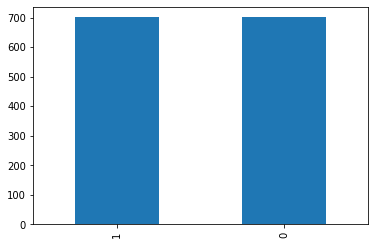

In [16]:
df['category'].value_counts().plot.bar()

## **4. See sample image**

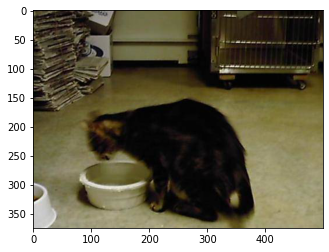

In [30]:
sample = random.choice(filenames)
image = load_img('/content/input/train/'+sample)
plt.imshow(image)

## **5. Build Model**
  - Input layer : 1D array로 변환
  - Conv layer : 이미지로부터 특징 추출
  - Pooling layer : 풀링 레이어를 활용해 이미지 픽셀의 크기 축소
  - Output layer : 최종적인 레이블 값을 예측하는 레이어

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation = 'softmax'))   # 2 because we have cat and dog classes

model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

## **6. Callbacks**

In [19]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

  - Early stop

In [20]:
earlystop = EarlyStopping(patience = 10)

  - Learning Rate Reduction

In [21]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',
                                            patience = 2,
                                            verbose = 1,
                                            factor = 0.5,
                                            min_lr = 0.00001)

In [22]:
callbacks = [earlystop, learning_rate_reduction]

## **7. Prepare data**

In [23]:
df['category'] = df['category'].replace({0: 'cat', 1: 'dog'})

In [24]:
train_df, validate_df = train_test_split(df, test_size = 0.2, random_state = 42)
train_df = train_df.reset_index(drop = True)
validate_df = validate_df.reset_index(drop = True)

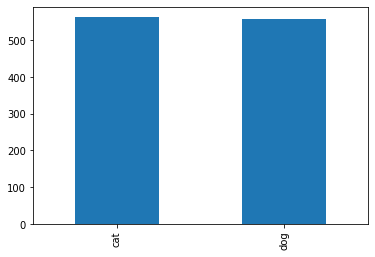

In [25]:
train_df['category'].value_counts().plot.bar()

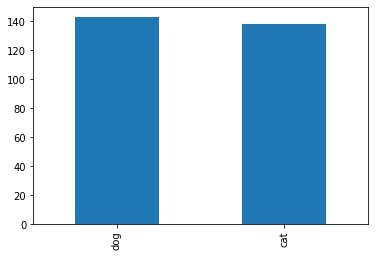

In [26]:
validate_df['category'].value_counts().plot.bar()

In [27]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 15

## **8. Training Generator**

In [32]:
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    rescale = 1./255,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    '/content/input/train/',
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 1121 validated image filenames belonging to 2 classes.


  - Validation Generator

In [33]:
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    '/content/input/train/',
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 281 validated image filenames belonging to 2 classes.


## **9. See how our generator work**

In [36]:
example_df = train_df.sample(n =1).reset_index(drop = True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    '/content/input/train',
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical'
)

Found 1 validated image filenames belonging to 1 classes.


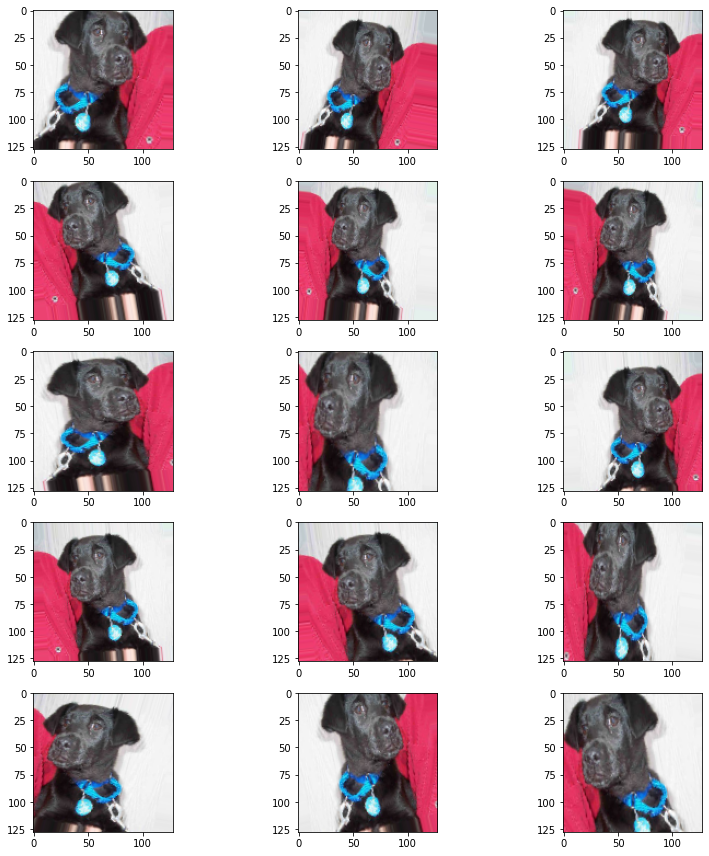

In [39]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## **10. Fit Model**

In [40]:
epochs = 3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = total_validate / batch_size,
    steps_per_epoch = total_train // batch_size,
    callbacks = callbacks
)

<ipython-input-40-40bc73b60331>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
74/74 [==============================] - ETA: 0s - loss: 1.3473 - accuracy: 0.5669

74/74 [==============================] - 61s 807ms/step - loss: 1.3473 - accuracy: 0.5669 - val_loss: 2.7034 - val_accuracy: 0.4911 - lr: 0.0010
Epoch 2/50
74/74 [==============================] - ETA: 0s - loss: 1.0763 - accuracy: 0.5778

74/74 [==============================] - 59s 796ms/step - loss: 1.0763 - accuracy: 0.5778 - val_loss: 4.2682 - val_accuracy: 0.4911 - lr: 0.0010
Epoch 3/50
74/74 [==============================] - ETA: 0s - loss: 0.9293 - accuracy: 0.5814

74/74 [==============================] - 57s 769ms/step - loss: 0.9293 - accuracy: 0.5814 - val_loss: 2.6436 - val_accuracy: 0.4911 - lr: 0.0010
Epoch 4/50
74/74 [==============================] - ETA: 0s - loss: 0.8279 - accuracy: 0.6040

74/74 [==============================] - 56s 752ms/step - loss: 0.8279 - accuracy: 0.6040 - val_loss: 2.4858 - val_accuracy: 0.4911 - lr: 0.0010
Epoch 5/50
74/74 [==============================] - ETA: 0s - loss: 0.7789 - accuracy: 0.6248

74/74 [==============================] - 56s 756ms/step - loss: 0.7789 - accuracy: 0.6248 - val_loss: 1.1789 - val_accuracy: 0.5231 - lr: 0.0010
Epoch 6/50
74/74 [==============================] - ETA: 0s - loss: 0.6721 - accuracy: 0.6609

74/74 [==============================] - 56s 755ms/step - loss: 0.6721 - accuracy: 0.6609 - val_loss: 1.3419 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 7/50
74/74 [==============================] - ETA: 0s - loss: 0.7242 - accuracy: 0.6193

74/74 [==============================] - 57s 766ms/step - loss: 0.7242 - accuracy: 0.6193 - val_loss: 0.6888 - val_accuracy: 0.6868 - lr: 0.0010
Epoch 8/50
74/74 [==============================] - ETA: 0s - loss: 0.6291 - accuracy: 0.6790

74/74 [==============================] - 56s 759ms/step - loss: 0.6291 - accuracy: 0.6790 - val_loss: 0.6637 - val_accuracy: 0.6797 - lr: 0.0010
Epoch 9/50
74/74 [==============================] - ETA: 0s - loss: 0.6269 - accuracy: 0.6881

74/74 [==============================] - 58s 783ms/step - loss: 0.6269 - accuracy: 0.6881 - val_loss: 0.6313 - val_accuracy: 0.6726 - lr: 0.0010
Epoch 10/50
74/74 [==============================] - ETA: 0s - loss: 0.6249 - accuracy: 0.6781

74/74 [==============================] - 56s 758ms/step - loss: 0.6249 - accuracy: 0.6781 - val_loss: 0.6984 - val_accuracy: 0.6441 - lr: 0.0010
Epoch 11/50
74/74 [==============================] - ETA: 0s - loss: 0.5945 - accuracy: 0.7143

74/74 [==============================] - 56s 758ms/step - loss: 0.5945 - accuracy: 0.7143 - val_loss: 0.5394 - val_accuracy: 0.7438 - lr: 0.0010
Epoch 12/50
74/74 [==============================] - ETA: 0s - loss: 0.5760 - accuracy: 0.7152

74/74 [==============================] - 58s 785ms/step - loss: 0.5760 - accuracy: 0.7152 - val_loss: 0.6094 - val_accuracy: 0.6975 - lr: 0.0010
Epoch 13/50
74/74 [==============================] - ETA: 0s - loss: 0.5817 - accuracy: 0.7007

74/74 [==============================] - 57s 771ms/step - loss: 0.5817 - accuracy: 0.7007 - val_loss: 0.6188 - val_accuracy: 0.6940 - lr: 0.0010
Epoch 14/50
74/74 [==============================] - ETA: 0s - loss: 0.5558 - accuracy: 0.7324

74/74 [==============================] - 57s 766ms/step - loss: 0.5558 - accuracy: 0.7324 - val_loss: 0.5641 - val_accuracy: 0.7011 - lr: 0.0010
Epoch 15/50
74/74 [==============================] - ETA: 0s - loss: 0.5579 - accuracy: 0.7269

74/74 [==============================] - 59s 802ms/step - loss: 0.5579 - accuracy: 0.7269 - val_loss: 0.9462 - val_accuracy: 0.5658 - lr: 0.0010
Epoch 16/50
74/74 [==============================] - ETA: 0s - loss: 0.5282 - accuracy: 0.7505

74/74 [==============================] - 57s 769ms/step - loss: 0.5282 - accuracy: 0.7505 - val_loss: 0.6379 - val_accuracy: 0.7046 - lr: 0.0010
Epoch 17/50
74/74 [==============================] - ETA: 0s - loss: 0.5506 - accuracy: 0.7414

74/74 [==============================] - 57s 772ms/step - loss: 0.5506 - accuracy: 0.7414 - val_loss: 0.5903 - val_accuracy: 0.7153 - lr: 0.0010
Epoch 18/50
74/74 [==============================] - ETA: 0s - loss: 0.5194 - accuracy: 0.7468

74/74 [==============================] - 57s 764ms/step - loss: 0.5194 - accuracy: 0.7468 - val_loss: 0.5220 - val_accuracy: 0.7509 - lr: 0.0010
Epoch 19/50
74/74 [==============================] - ETA: 0s - loss: 0.5248 - accuracy: 0.7477

74/74 [==============================] - 59s 792ms/step - loss: 0.5248 - accuracy: 0.7477 - val_loss: 0.5566 - val_accuracy: 0.7224 - lr: 0.0010
Epoch 20/50
74/74 [==============================] - ETA: 0s - loss: 0.5029 - accuracy: 0.7631

74/74 [==============================] - 57s 766ms/step - loss: 0.5029 - accuracy: 0.7631 - val_loss: 0.7654 - val_accuracy: 0.6157 - lr: 0.0010
Epoch 21/50
74/74 [==============================] - ETA: 0s - loss: 0.5080 - accuracy: 0.7595

74/74 [==============================] - 65s 877ms/step - loss: 0.5080 - accuracy: 0.7595 - val_loss: 0.5666 - val_accuracy: 0.7331 - lr: 0.0010
Epoch 22/50
74/74 [==============================] - ETA: 0s - loss: 0.5194 - accuracy: 0.7450

74/74 [==============================] - 102s 1s/step - loss: 0.5194 - accuracy: 0.7450 - val_loss: 0.5429 - val_accuracy: 0.7331 - lr: 0.0010
Epoch 23/50
74/74 [==============================] - ETA: 0s - loss: 0.5315 - accuracy: 0.7432

74/74 [==============================] - 61s 817ms/step - loss: 0.5315 - accuracy: 0.7432 - val_loss: 0.5522 - val_accuracy: 0.7367 - lr: 0.0010
Epoch 24/50
74/74 [==============================] - ETA: 0s - loss: 0.4890 - accuracy: 0.7703

74/74 [==============================] - 64s 864ms/step - loss: 0.4890 - accuracy: 0.7703 - val_loss: 0.5322 - val_accuracy: 0.7651 - lr: 0.0010
Epoch 25/50
74/74 [==============================] - ETA: 0s - loss: 0.5084 - accuracy: 0.7541

74/74 [==============================] - 60s 810ms/step - loss: 0.5084 - accuracy: 0.7541 - val_loss: 0.5917 - val_accuracy: 0.7402 - lr: 0.0010
Epoch 26/50
74/74 [==============================] - ETA: 0s - loss: 0.4882 - accuracy: 0.7676

74/74 [==============================] - 57s 773ms/step - loss: 0.4882 - accuracy: 0.7676 - val_loss: 0.5605 - val_accuracy: 0.7687 - lr: 0.0010
Epoch 27/50
74/74 [==============================] - ETA: 0s - loss: 0.4523 - accuracy: 0.7920

74/74 [==============================] - 59s 801ms/step - loss: 0.4523 - accuracy: 0.7920 - val_loss: 0.5350 - val_accuracy: 0.7829 - lr: 0.0010
Epoch 28/50
74/74 [==============================] - ETA: 0s - loss: 0.4700 - accuracy: 0.7839

74/74 [==============================] - 60s 808ms/step - loss: 0.4700 - accuracy: 0.7839 - val_loss: 0.5812 - val_accuracy: 0.7865 - lr: 0.0010


## **11. Save Model**

In [41]:
model.save_weights('model.h5')

## **12. Virtualize Training**

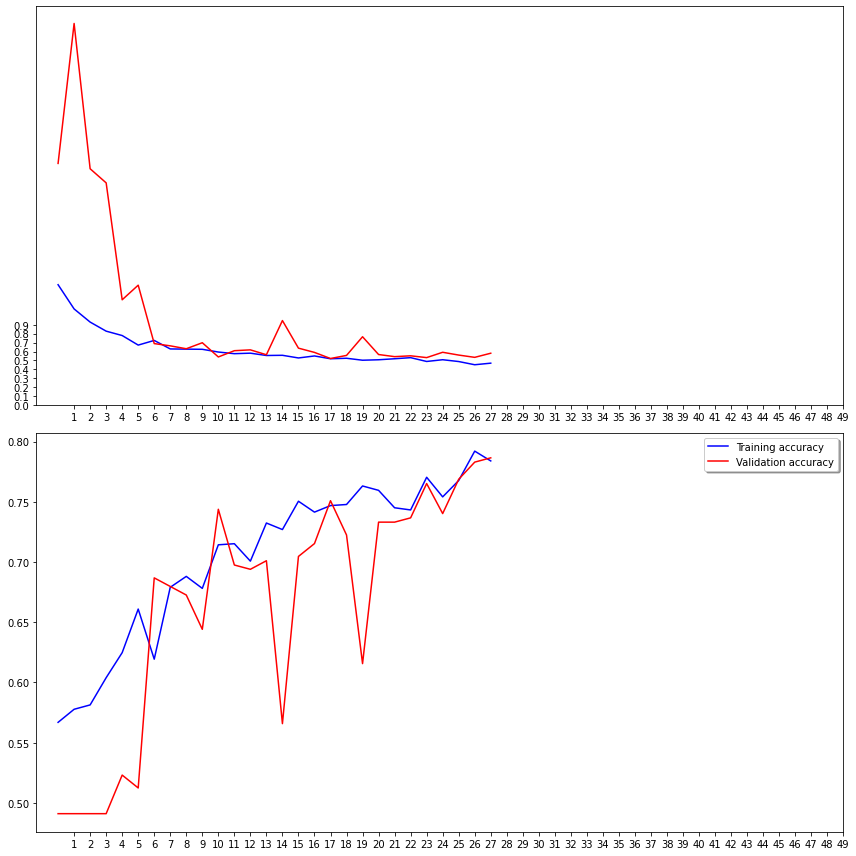

In [42]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 12))
ax1.plot(history.history['loss'], color = 'b', label = 'Training loss')
ax1.plot(history.history['val_loss'], color = 'r', label = 'validation loss')
ax1.set_xticks(np.arange(1, epochs , 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color = 'b', label = 'Training accuracy')
ax2.plot(history.history['val_accuracy'], color = 'r', label = 'Validation accuracy')
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc = 'best', shadow = True)
plt.tight_layout()
plt.show()

## **13. Prepare Testing Data**

In [44]:
test_filenames = os.listdir('/content/input/test/')
test_df = pd.DataFrame({
    'filename' : test_filenames
})

nb_samples = test_df.shape[0]

## **14. Create Testing Generator**

In [45]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    '/content/input/test/',
    x_col = 'filename',
    y_col = None,
    class_mode = None,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    shuffle = False
)

Found 1402 validated image filenames.


## **15. Predict**

In [46]:
predict = model.predict_generator(test_generator, steps = np.ceil(nb_samples/batch_size))

<ipython-input-46-541b7393bc38>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps = np.ceil(nb_samples/batch_size))


In [47]:
test_df['category'] = np.argmax(predict, axis = -1)

In [48]:
label_map = dict((v, k) for k, v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [49]:
test_df['category'] = test_df['category'].replace({'dog' : 1, 'cat' : 0})

  - Virtualize Result

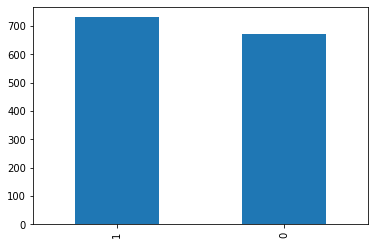

In [50]:
test_df['category'].value_counts().plot.bar()

  - See predicted result with images

In [52]:
sample_test = test_df.head(18)
sample_test.head()

plt.figure(figsize = (12, 24))
for index, row in sample_test.iterrows():
  filename = row['filename']
  category = row['category']
  img = load_img('/content/input/test/'+filename, target_size = IMAGE_SIZE)
  plt.subplot(6, 3, index+1)
  plt.imshow(img)
  plt.xlabel(filename + '(' + '{}'.format(category) + ')')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.